In [205]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [206]:
df = pd.read_csv('../datasets/microsoft.csv',index_col='Date')
df.head(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1986-03-13,0.088542,0.101563,0.088542,0.097222,0.061434,1031788800
1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063628,308160000
1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064725,133171200


In [207]:
df['Mean'] = (df['High'] + df['Low'])/2
df.head(3)

,Open,High,Low,Close,Adj Close,Volume,Mean
Date,,,,,,,
1986-03-13,0.088542,0.101563,0.088542,0.097222,0.061434,1031788800,0.095052
1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063628,308160000,0.099826
1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064725,133171200,0.101997


In [208]:
df.shape

(9083, 7)

In [209]:
df = df[-300:]
df.head()

,Open,High,Low,Close,Adj Close,Volume,Mean
Date,,,,,,,
2021-01-15,213.520004,214.509995,212.029999,212.649994,210.447174,31746500,213.269997
2021-01-19,213.750000,216.979996,212.630005,216.440002,214.197922,30480900,214.805001
2021-01-20,217.699997,225.789993,217.289993,224.339996,222.016068,37777300,221.539993
2021-01-21,224.699997,226.300003,222.419998,224.970001,222.639557,30709400,224.360001
2021-01-22,227.080002,230.070007,225.800003,225.949997,223.609390,30172700,227.935005


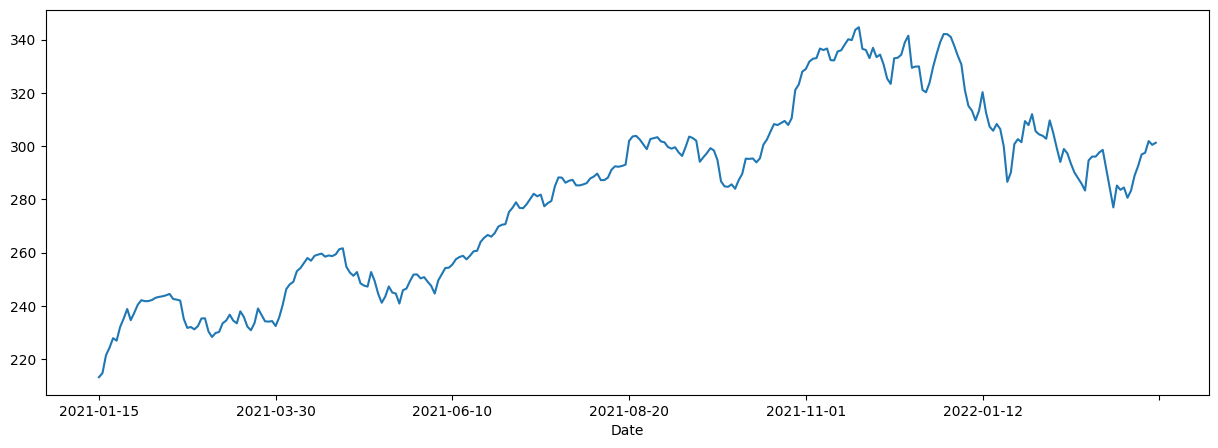

In [210]:
df['Mean'].plot(figsize=(15,5))
plt.show()

In [211]:

from statsmodels.tsa.arima.model import ARIMA

df.index.freq = 'MS'
Ntest = 20
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [213]:
from statsmodels.tsa.stattools import adfuller

adfuller(df['Mean'])

(-1.9486979303827818,
 0.3095099605386095,
 1,
 298,
 {'1%': -3.4524859843440754,
  '5%': -2.871288184343229,
  '10%': -2.571964047565425},
 1506.2659298526746)

In [214]:
def adf(x):
    res = adfuller(x)
    print('Test-Statistic', res[0])
    print('P-value', res[1])

    if res[1] < 0.05:
        print("Stationary")
    else:
        print("Non-Stationary")

In [215]:
adf(df['Mean'])

Test-Statistic -1.9486979303827818
P-value 0.3095099605386095
Non-Stationary


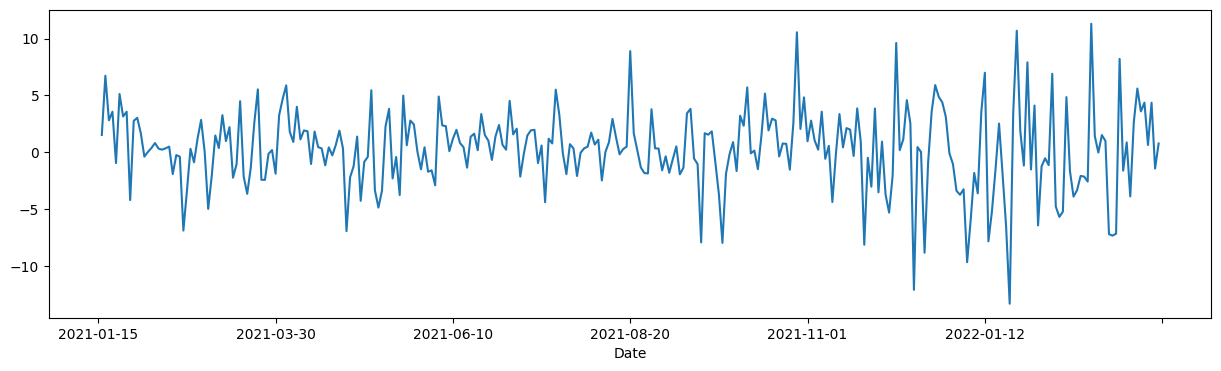

In [216]:
df['Diff'] = df['Mean'].diff()
df['Diff'].plot(figsize=(15,4))
plt.show()

In [217]:
df = df.dropna()

In [218]:
df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Mean         0
Diff         0
dtype: int64

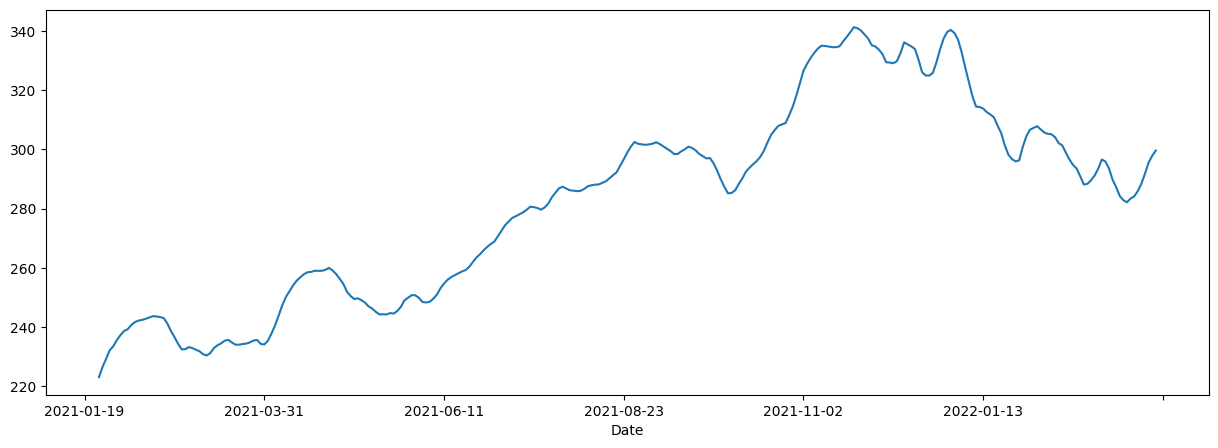

In [219]:
rolling_diff = df['Mean'].rolling(window=5).mean()
rolling_diff.plot(figsize=(15,5))
plt.show()

In [220]:
rolling_diff.head()

Date
2021-01-19        NaN
2021-01-20        NaN
2021-01-21        NaN
2021-01-22        NaN
2021-01-25    223.128
Name: Mean, dtype: float64

In [221]:
rolling_diff = rolling_diff.dropna()

In [222]:
rolling_diff = rolling_diff.reset_index()

In [223]:
rolling_diff.set_index('Date', inplace=True)

In [224]:
rolling_diff['LogMean'] = np.log(rolling_diff['Mean'])
rolling_diff.head()

,Mean,LogMean
Date,,
2021-01-25,223.128000,5.407746
2021-01-26,226.592999,5.423155
2021-01-27,229.343001,5.435219
2021-01-28,232.244000,5.447789
2021-01-29,233.594000,5.453585


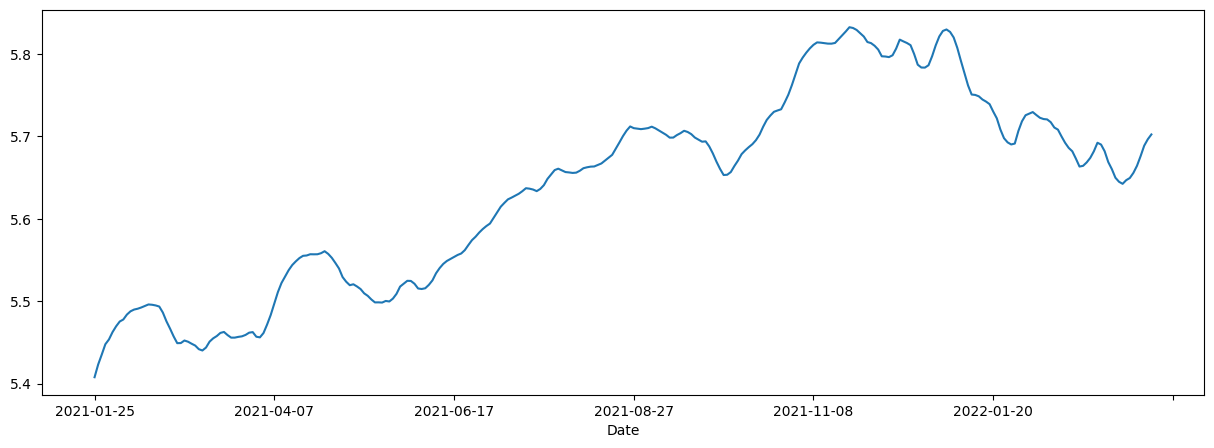

In [225]:
rolling_diff["LogMean"].plot(figsize=(15,5))
plt.show()

In [226]:
from statsmodels.tsa.arima.model import ARIMA

rolling_diff.index.freq = 'MS'
Ntest = 12
train = rolling_diff.iloc[:-Ntest]
test = rolling_diff.iloc[-Ntest:]

In [227]:
train_idx = rolling_diff.index <= train.index[-1]
test_idx = rolling_diff.index > train.index[-1]

In [228]:
arima = ARIMA(train['LogMean'], order=(1,0,0))

d:\files\Data Science\ds\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\files\Data Science\ds\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\files\Data Science\ds\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [229]:
arima_result = arima.fit()

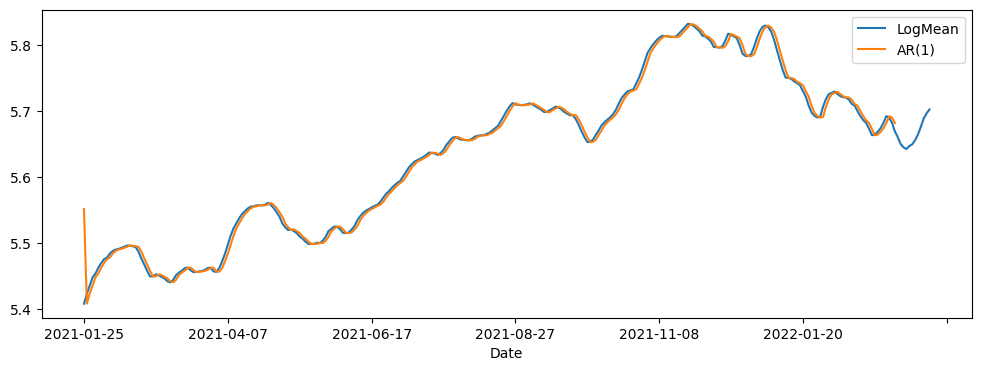

In [230]:
rolling_diff.loc[train_idx, 'AR(1)'] = arima_result.predict(start=train.index[0], end=train.index[-1])
rolling_diff[['LogMean','AR(1)']].plot(figsize=(12,4))
plt.show()

In [231]:
def plot_fit_and_forecast(result):
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(rolling_diff['LogMean'], label='data')

    train_pred = result.fittedvalues
    ax.plot(train.index, train_pred, color='green', label='fitted')

    prediction_result = result.get_forecast(Ntest)
    conf_int = prediction_result.conf_int()
    lower, upper = conf_int['lower LogMean'], conf_int['upper LogMean']
    forecast = prediction_result.predicted_mean
    
    ax.plot(test.index, forecast, label='forecast')
    ax.fill_between(test.index,lower,upper,color='red',alpha=0.3)
    ax.legend()

In [232]:
prediction_result = arima_result.get_forecast(Ntest)
forecast = prediction_result.predicted_mean
rolling_diff.loc[test_idx,'AR(1)'] = forecast

d:\files\Data Science\ds\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [233]:
prediction_result.conf_int()

,lower LogMean,upper LogMean
283,5.657254,5.680459
284,5.652343,5.685143
285,5.648553,5.688706
286,5.645345,5.691687
287,5.642509,5.694297
288,5.639939,5.696641
289,5.637569,5.698785
290,5.635358,5.700770
291,5.633278,5.702624
292,5.631308,5.704369


d:\files\Data Science\ds\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


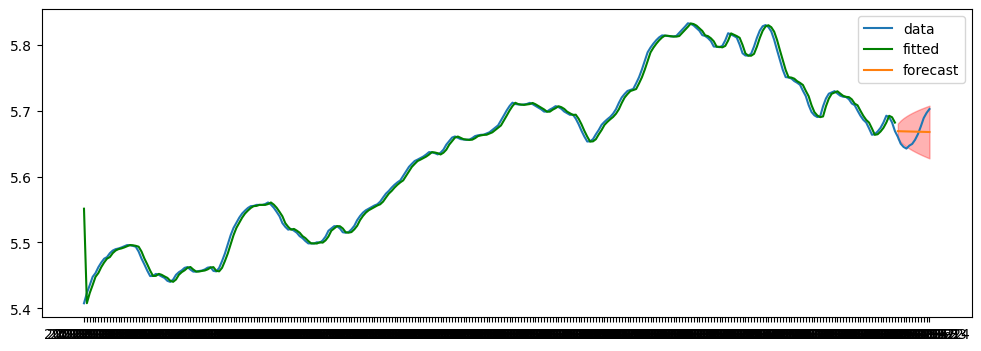

In [234]:
plot_fit_and_forecast(arima_result)

d:\files\Data Science\ds\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\files\Data Science\ds\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\files\Data Science\ds\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\files\Data Science\ds\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


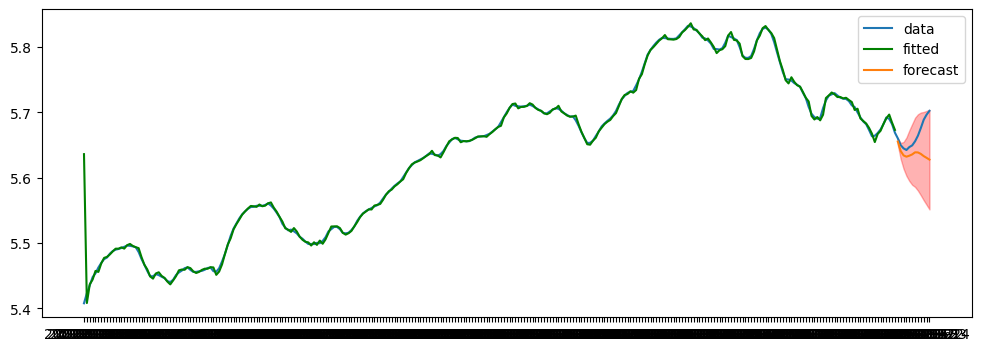

In [235]:
arima = ARIMA(train['LogMean'], order=(10,0,0))
arima_result = arima.fit()
plot_fit_and_forecast(arima_result)